# CMIP6 model DHM and ASB results, following the business as usual 'ssp585' scenario

Note that at present there are not many CMIP6 model results available. Here I've used all I can get hold of

In [2]:
import iris
import iris.coord_categorisation
import matplotlib.pyplot as plt
import numpy as np
import iris.quickplot as qplt
import netCDF4
import datetime
import scipy
import scipy.signal
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy


directory = '/Users/ph290/Downloads/revelle2/'

/Users/ph290/miniconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [3]:
def extract_region(cube,lon_west,lon_east,lat_south,lat_north):
    cube_region_tmp = cube.intersection(longitude=(lon_west, lon_east))
    cube_region = cube_region_tmp.intersection(latitude=(lat_south, lat_north))
    return cube_region

In [4]:
def area_avg(cube):
    try:
        cube.coord('latitude').guess_bounds()
        cube.coord('longitude').guess_bounds()
    except:
        pass
    grid_areas = iris.analysis.cartography.area_weights(cube)
    return cube.collapsed(['longitude','latitude'],iris.analysis.MEAN, weights=grid_areas)

def area_max(cube):
    return cube.collapsed(['longitude','latitude'],iris.analysis.MAX)

In [5]:
def mmm_for_dhm(cube):
    years_for_mmm_climatology = [1985,2000]
    #####################################################
    #Avreage months separately!!!!!!!!!!!
#####################################################
    cube_years = cube.coord('year').points
    #subset the data into the bit you want to use to calculate the MMM climatology and the bit you want to calculate DHW on
    clim_cube = cube[np.where((cube_years >= years_for_mmm_climatology[0]) & (cube_years <= years_for_mmm_climatology[1]))]
    #collapse the months together, taking the maximum value at each lat-lon grid square
    mmm_climatology = clim_cube.collapsed('time',iris.analysis.MAX)
    return mmm_climatology




In [6]:
def dhm(cube,mmm_climatology,years_over_which_to_calculate_dhm):
    missing_data_value = cube.data.fill_value
    #This hsould be given monthly data
    # One DHM == 4DHW This is important
#     mmm is straight averg not fdetreneded for DHM
    #Look at the donna poapers - look over two papers...
    #accumulation window is 4 months rather than 3 months.
    cube_years = cube.coord('year').points
#     print cube_years
#     print years_over_which_to_calculate_dhm[0]
#     print years_over_which_to_calculate_dhm[1]
    main_cube = cube[np.where((cube_years >= years_over_which_to_calculate_dhm[0]) & (cube_years <= years_over_which_to_calculate_dhm[1]))]
    main_cube_data = main_cube.data.copy()
    main_cube_data[np.where(main_cube_data == missing_data_value )] = np.nan
    main_cube.data = main_cube_data
    
    #subtract the monthly mean climatology from the rest of the data
    main_cube -= mmm_climatology # at this stage this is called a hot spot (which is anything greater than the mmm)

    #set all values less than 1 to zero
#     main_cube.data[np.where(main_cube.data <= 1.0)] = 0.0
    #OR
    main_cube_data = main_cube.data.copy()
    main_cube_data[np.where(main_cube_data < 0.0)] = 0.0
#     main_cube_data[np.where(main_cube_data == missing_data_value )] = np.nan
    main_cube.data = main_cube_data
    
    #make a cube to hold the output data
    output_cube = main_cube[3::].copy()
    output_cube.data[:] = np.nan
    output_cube_data = output_cube.data.copy()

        #AVEREG OVER A 4 month  window rather than 3 month when it comes to DHW


    #loop through from day 112 to the end of the dataset
    for i in range(output_cube.shape[0]):
#         print i,' of ',output_cube.shape[0]
        tmp_data = main_cube[i:i+4].collapsed('time',iris.analysis.SUM)
        output_cube_data[i,:,:] = tmp_data.data

    #save the output
    output_cube.data = output_cube_data
    return output_cube

In [7]:
def merge_two_cubes(cubes):
    data1 = cubes[0].data
    data2 = cubes[1].data
    data = np.concatenate([data1,data2],axis=0)
    data = np.ma.masked_where(data == cubes[0].data.fill_value, data)

    length = cubes[0].shape[0] + cubes[1].shape[0]
    datetime_object1 = netCDF4.num2date(cubes[0].coord('time').points,cubes[0].coord('time').units.name,cubes[0].coord('time').units.calendar)
    datetime_object2 = netCDF4.num2date(cubes[1].coord('time').points,cubes[1].coord('time').units.name,cubes[1].coord('time').units.calendar)
    datetime_object = np.concatenate([datetime_object1,datetime_object2])
    try:
        tmp =  [x._to_real_datetime() - datetime.datetime(1850,1,1) for x in datetime_object]
    except:
        tmp =  [x - datetime.datetime(1850,1,1) for x in datetime_object]
    days_since_18500101 = [x.days for x in tmp]

    time = iris.coords.DimCoord(days_since_18500101, standard_name='time',long_name=u'time', var_name='time', units='days since 1850-1-1')
    latitude = iris.coords.DimCoord(range(-90, 90, 1), standard_name='latitude', units='degrees')
    longitude = iris.coords.DimCoord(range(0, 360, 1), standard_name='longitude', units='degrees')
    cube = iris.cube.Cube(data,standard_name='sea_surface_temperature',long_name='Sea Surface Temperature', var_name='tos', units='K',dim_coords_and_dims=[(time,0), (latitude, 1),
    (longitude, 2)])
    iris.coord_categorisation.add_year(cube, 'time', name='year')
    iris.coord_categorisation.add_month(cube, 'time', name='month')
    iris.coord_categorisation.add_month_number(cube, 'time', name='month_number')
    return cube

set up the dictonary with model names

In [8]:
models = ['BCC-CSM2-MR','CanESM5','MPI-ESM1-2-HR','CESM2','MIROC6','MRI-ESM2-0']

colors = ['r','g','b','k','m','c']
model_dict = {}
for i,model in enumerate(models):
    model_dict[model] = {}
    model_dict[model]['color'] = colors[i]


# BCC-CSM2-MR_tos_historical_r1i1p1f1_gn.nc	BCC-CSM2-MR_tos_ssp585_r1i1p1f1_gn.nc

read in the model data

In [9]:
cube_dict = {}

for model in models:
    cube_dict[model] = {}
    # file = glob.glob(model+'_tos_*_r1i1p1f1_gn.nc')
    # print file

    cubes = iris.load(directory+model+'_tos_*_r1i1p1f1_gn.nc')
    # cubes2 = iris.load(model+'_tos_ssp585_r1i1p1f1_gn.nc')
    # cubes = iris.cube.CubeList([cubes1,cubes2])

    cube =  merge_two_cubes(cubes)
    cube_dict[model]['cube'] = cube




/Users/ph290/miniconda2/lib/python2.7/site-packages/iris/fileformats/cf.py:798: UserWarning: Missing CF-netCDF measure variable u'areacello', referenced by netCDF variable u'tos'
  warnings.warn(message % (variable_name, nc_var_name))
/Users/ph290/miniconda2/lib/python2.7/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


IGNORE FOR NOW testing with 3hourly sst to compare day and night

In [10]:
# file = '/data/BatCaveNAS/ph290/cmip6/tmp2/processed/tos_3hr_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_regridded.nc'
# cube = iris.load_cube(file)

## calculate DHMs

In [11]:
for model in models:
    print model
    years_over_which_to_calculate_dhm = [2012,2100]
    mmm_climatology = mmm_for_dhm(cube_dict[model]['cube'])
    dhm_cube = dhm(cube_dict[model]['cube'],mmm_climatology,years_over_which_to_calculate_dhm)
    lon_west = 142.0
    lon_east = 157.0
    lat_south = -30.0
    lat_north = -10.0
    dhm_cube_gbr = extract_region(dhm_cube,lon_west,lon_east,lat_south,lat_north)
    cube_dict[model]['dhm'] = dhm_cube_gbr
    

BCC-CSM2-MR


/Users/ph290/miniconda2/lib/python2.7/site-packages/iris/coords.py:1017: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/Users/ph290/miniconda2/lib/python2.7/site-packages/iris/coords.py:1017: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'month_number'.
  warnings.warn(msg.format(self.name()))
/Users/ph290/miniconda2/lib/python2.7/site-packages/iris/coords.py:1017: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'year'.
  warnings.warn(msg.format(self.name()))


CanESM5
MPI-ESM1-2-HR
CESM2
MIROC6
MRI-ESM2-0


In [12]:
def asb(cube,threshold):
    dhm_cube_gbr_tmp = cube.copy()
    dhm_cube_gbr_tmp_data = dhm_cube_gbr_tmp.data
    dhm_cube_gbr_tmp_data[np.where(dhm_cube_gbr_tmp_data <= threshold)] = 0.0
    dhm_cube_gbr_tmp_data[np.where(dhm_cube_gbr_tmp_data > threshold)] = 1.0
    dhm_cube_gbr_tmp.data = dhm_cube_gbr_tmp_data
    dhm_cube_gbr_asb = dhm_cube_gbr.copy()
    dhm_cube_gbr_asb = dhm_cube_gbr_tmp.aggregated_by(['year'], iris.analysis.SUM)
    dhm_cube_gbr_asb_tmp = dhm_cube_gbr_asb.data
    dhm_cube_gbr_asb_tmp[np.where(dhm_cube_gbr_asb_tmp > 1.0)] = 1.0
    dhm_cube_gbr_asb.data = dhm_cube_gbr_asb_tmp
    dhm_cube_gbr_asb.data.mask = cube.data.mask
    return dhm_cube_gbr_asb
    
for model in models:
    dhm_cube_gbr = extract_region(cube_dict[model]['dhm'],lon_west,lon_east,lat_south,lat_north)
    dhm_cube_gbr_asb = asb(dhm_cube_gbr,2.0) # 2.0 because that is equivilantish to dhw of 4
    cube_dict[model]['dhm_gbr'] = dhm_cube_gbr
    cube_dict[model]['asb'] = dhm_cube_gbr_asb
    cube_dict[model]['asb_avg'] = area_avg(dhm_cube_gbr_asb)
    cube_dict[model]['dhm_avg'] = area_avg(dhm_cube_gbr.aggregated_by(['year'], iris.analysis.MEAN))
    cube_dict[model]['asb_max'] = area_max(dhm_cube_gbr_asb)
    cube_dict[model]['dhm_max'] = area_max(dhm_cube_gbr.aggregated_by(['year'], iris.analysis.MAX))

/Users/ph290/miniconda2/lib/python2.7/site-packages/iris/analysis/cartography.py:376: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")
/Users/ph290/miniconda2/lib/python2.7/site-packages/iris/coords.py:1017: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/Users/ph290/miniconda2/lib/python2.7/site-packages/iris/coords.py:1017: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))


# example showing Maximum DHM across all years from one model so the region I'm using is clear

/Users/ph290/miniconda2/lib/python2.7/site-packages/iris/coords.py:826: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/Users/ph290/miniconda2/lib/python2.7/site-packages/iris/coords.py:826: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


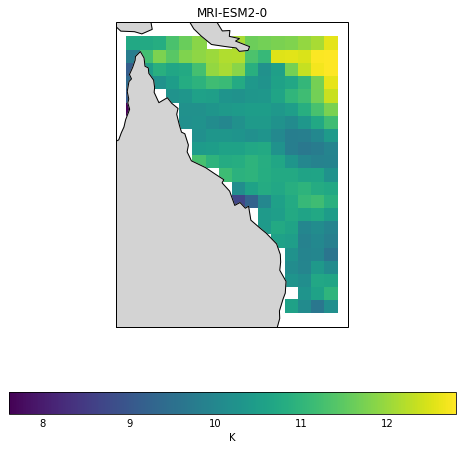

In [13]:
land_110m = cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                        edgecolor='face',
                                        facecolor = '#d3d3d3')

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
qplt.pcolormesh(cube_dict[model]['dhm'].collapsed('time',iris.analysis.MAX))
ax.add_feature(land_110m)
plt.gca().coastlines()
plt.title(model)
qplt.show()

## GBR Annual Severe Bleaching (defined as a DHM > 2.0) per model per year, area averaged. 1.0 on the y-axis would mean that every grid cell experienced ASB in that year

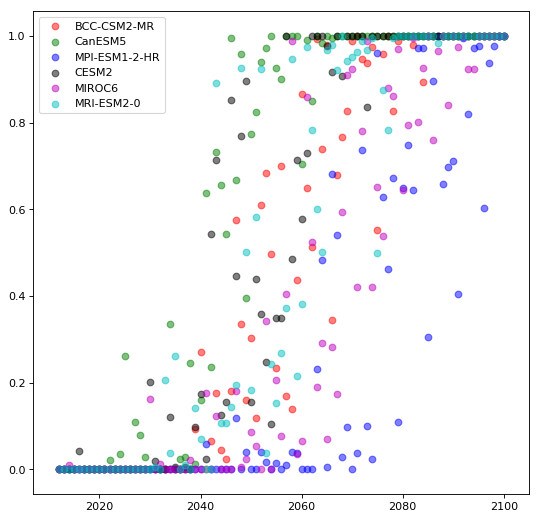

In [14]:
plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')


for model in models:
#     print cube_dict[model]['asb'].coord('year').points
#     y = cube_dict[model]['asb_avg'].data
#     y[np.where(y > 0.0)] = 1
    plt.scatter(cube_dict[model]['asb'].coord('year').points,cube_dict[model]['asb_avg'].data,alpha=0.5,color=model_dict[model]['color'],label = model)

# plt.ylim([-0.1,1.1])
plt.legend()
plt.show()

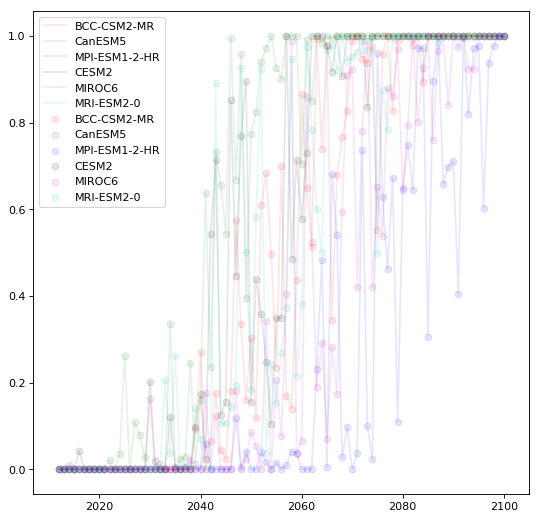

In [20]:
plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

for model in models:
    plt.plot(cube_dict[model]['asb'].coord('year').points,cube_dict[model]['asb_avg'].data,alpha=0.1,color=model_dict[model]['color'],label = model)
    plt.scatter(cube_dict[model]['asb'].coord('year').points,cube_dict[model]['asb_avg'].data,alpha=0.1,color=model_dict[model]['color'],label = model)

# plt.ylim([-0.1,1.1])
plt.legend()
plt.show()

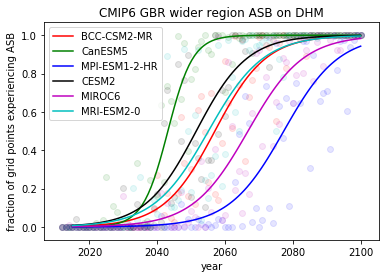

In [75]:
import scipy.optimize

def sigmoid(x,a,b):
    y = 1.0/(1.0 + np.exp(-b*(x-a)))
    return y

for model in models:
    xdata,ydata = cube_dict[model]['asb'].coord('year').points,cube_dict[model]['asb_avg'].data
    plt.scatter(xdata,ydata,alpha=0.1,color=model_dict[model]['color'])
    popt,pcov = scipy.optimize.curve_fit(sigmoid,xdata,ydata,p0=[1000,0.00001])
    x = np.linspace(2015,2100,100)
    y= sigmoid(x,*popt)
    plt.plot(x,y,'k',alpha=1.0,color=model_dict[model]['color'],label = model)

plt.legend()
plt.xlabel('year')
plt.ylabel('fraction of grid points experiencing ASB')
plt.title('CMIP6 GBR wider region ASB on DHM')

plt.savefig('cmip6_asb.png',dpi=300)



## GBR Maximum DHM experienced in any grid-cell per year for each CMIP6 model

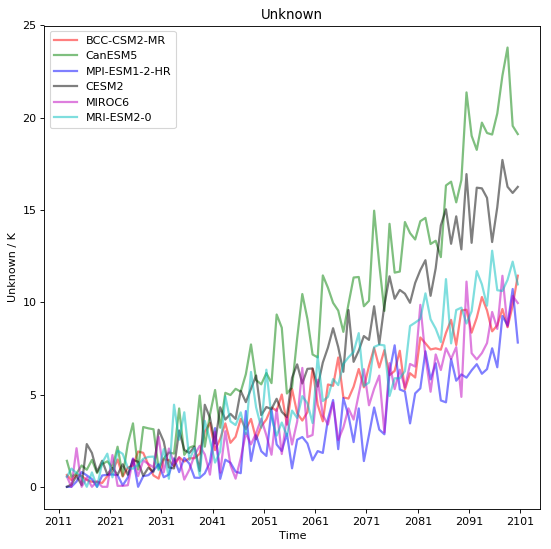

In [15]:
plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

# for model in models:
#     qplt.plot(cube_dict[model]['dhm_cube_Spillman_2013_avg'],lw = 2,alpha=0.5,color=model_dict[model]['color'])

    
for model in models:
    qplt.plot(cube_dict[model]['dhm_max'],lw=2,color=model_dict[model]['color'],label = model,alpha=0.5)

# plt.plot()

# plt.ylim([0,0.5])
plt.legend()

In [16]:

# land_110m = cfeature.NaturalEarthFeature('physical', 'land', '110m',edgecolor='face',facecolor=(0.85, 0.85, 0.85))

# for i,model in enumerate(models):
#     fig = plt.figure()
#     ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
#     qplt.pcolormesh(cube_dict[model]['asb'][0:20].collapsed('time',iris.analysis.MAX),vmin=0,vmax=1)
#     ax.add_feature(land_110m)
#     plt.gca().coastlines()
#     plt.title(model)
#     qplt.show()